In [1]:
# 1 Import libraries and modules + custom function definitions

import numpy as np
np.random.seed(123)  # for reproducibility
from keras.models import Sequential
from keras.optimizers import *
from keras.regularizers import l2
from keras.layers import *
from keras.utils.np_utils import to_categorical
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
from skimage.io import imread
from sklearn.model_selection import train_test_split
import pandas as pd
import keras
import glob
import platform

def reshape_to_view_img(img):
    '''
    Given an image of dimensions (x,y,1)
    convert it to (x,y) to be able to view it
    '''
    
    (x,y) = (img.shape[0],img.shape[1])
    return np.reshape(img,(x,-1,))

Using TensorFlow backend.
/home/antonis/anaconda2/envs/kaggle/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
from keras.callbacks import ReduceLROnPlateau,EarlyStopping

In [3]:
#verify GPU is up n running
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15952797368417500996
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 78249984
locality {
  bus_id: 1
}
incarnation: 688468256266613664
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [4]:
# 2 Load data + initialize variables

train_labels = pd.read_csv('train_onelabel.csv',index_col='image')
get_class_of = train_labels['class'].to_dict()                                             #dict image->class
get_images_of = train_labels.groupby('class').apply(lambda x: x.values.tolist()).to_dict() #dict ???

input_size = (64, 64)
output_size = len(list(train_labels['class'].unique()))

label_map = pd.read_csv('label_map.txt',header=None,names=['name','id'],sep=' ')
get_name_of_class = label_map['name'].to_dict()
''' get_name_of_class[9] >> 'ctenophore_cydippid_tentacles' '''
get_class_name_of = {v: k for k, v in get_name_of_class.items()}
''' get_class_name_of['ctenophore_cydippid_tentacles'] >> 9 '''

training_paths_list = glob.glob('competition_data/train_images/*')     #normal (not numpy) list of str  
test_set_list = glob.glob('competition_data/test_images/*')          #normal (not numpy) list of str 

# savedmodelpath = 'trainHistory/12-08 18.54, train_err=0.70, test_err=0.73double_kernel_size_termatismeno.h5'

In [5]:
#model parameters
batch_size=64
reg_lambda = 0.01/255
dropout_value=0.25

In [6]:
#handle imbalanced classes

#Read training data
df = pd.read_csv('train_onelabel.csv',index_col='image')

class_counts = df['class'].value_counts()
# class_weights = np.log(class_counts)

In [7]:

class_weights = np.e**(1/class_counts)
print(class_weights)
class_weights = class_weights.to_dict()

58     1.000633
84     1.000643
105    1.001037
12     1.001060
45     1.001373
3      1.001411
101    1.001423
99     1.001552
34     1.001750
67     1.001753
26     1.001787
100    1.001794
8      1.001817
117    1.001847
27     1.002018
70     1.002339
21     1.002356
32     1.002442
53     1.002528
49     1.002554
61     1.002656
31     1.002837
36     1.002963
104    1.002972
11     1.003091
0      1.003110
119    1.003180
6      1.003241
113    1.003396
81     1.003490
         ...   
77     1.029849
69     1.031743
25     1.032784
96     1.035084
98     1.035084
87     1.037731
108    1.039211
55     1.042547
107    1.044437
82     1.044437
102    1.044437
86     1.046503
15     1.051271
90     1.051271
48     1.054041
115    1.057128
57     1.057128
83     1.064494
33     1.068939
120    1.079959
79     1.079959
62     1.095169
30     1.095169
13     1.105171
95     1.117519
65     1.117519
106    1.117519
41     1.153565
85     1.153565
10     1.153565
Name: class, Length: 121

In [8]:
class_counts = df['class'].value_counts()

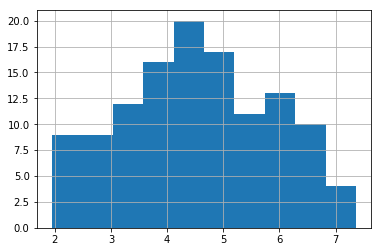

In [9]:
class_weights = np.log(class_counts)
class_weights.hist()

In [10]:
# 3 Load & Preprocess input data

def inverse_grayscale(pixel_value):
    return (255.-pixel_value)
def inverse_scale_center(pixel_value):
    return (((255.-pixel_value)/255)-0.5)
v_inverse_grayscale = np.vectorize(inverse_grayscale)
v_inverse_scale_center = np.vectorize(inverse_scale_center)

input_size = (64,64)      # ! parameter
training_images = (load_img(p, target_size=input_size, grayscale=True) for p in training_paths_list)
traning_images_array = np.array([img_to_array(im) for im in training_images]) #numpy array of numpy arrays (pictures) (X_train)
del training_images

test_images = (load_img(p, target_size=input_size,grayscale=True) for p in test_set_list)
test_images_array = np.array([img_to_array(im) for im in test_images])
del test_images

if (platform.system()=='Windows'):
    all_labels = list(map(lambda p: get_class_of[p.split('\\')[-1]] , training_paths_list))
else:
    all_labels = list(map(lambda p: get_class_of[p.split('/')[-1]] , training_paths_list))

traning_images_array = v_inverse_scale_center(traning_images_array)   #apply inverse grayscale transformation before splitting to train+validation
test_images_array = v_inverse_scale_center(test_images_array)         #apply inverse grayscale transformation to test data as well

# We will take ALL images for the final training
# traning_images_array, validation_images_array, train_labels , validation_labels = train_test_split(traning_images_array, 
#                                                                                                    to_categorical(all_labels), 
#                                                                                                    stratify=to_categorical(all_labels), 
#                                                                                                    test_size=0.2, random_state=41)

#split training and cross validation data


traning_images_array = traning_images_array.astype('float32')
# validation_images_array = validation_images_array.astype('float32')
test_images_array = test_images_array.astype('float32')


In [11]:
traning_images_array.shape

(24204, 64, 64, 1)

In [12]:
train_labels.shape

(24204, 1)

In [13]:
# Image Augmentation
train_datagen = ImageDataGenerator(rotation_range=90,
                                   featurewise_center=True,
                                   featurewise_std_normalization=True,
                                    samplewise_std_normalization=False,
                                    samplewise_center=False,
                                   #rescale=1./255.,
                                   #zca_whitening=True,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   zoom_range=0.1,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range = (20/360)*(2*np.pi)
                                )


test_datagen = ImageDataGenerator(
            featurewise_center=True,
            featurewise_std_normalization=True,
            samplewise_std_normalization=False,
            samplewise_center=False,
        )

# test_datagen2 = ImageDataGenerator(
#             featurewise_center=True,
#             featurewise_std_normalization=True,
#             samplewise_std_normalization=False,
#             samplewise_center=False,
#         )



train_datagen.fit(traning_images_array)    #used for zca whitening/featurewise_center & normalization

#apply 2nd fit

#tran_dataset: fit στα a)train, b)test data
#a
#test_datagen.fit(train_images_array)
#b
test_datagen.fit(test_images_array)

# test_datagen.fit(test_images_array)
# test_datagen2.fit(traning_images_array)

####

# validation_images_array = validation_images_array.astype('float32')
# val_datagen = ImageDataGenerator(
#             featurewise_center=True,
#             featurewise_std_normalization=True,
#             samplewise_std_normalization=False,
#             samplewise_center=False,
#         )
# val_datagen.fit(validation_images_array)    #used for zca whitening/featurewise_center & normalization




In [14]:
traning_images_array.shape

(24204, 64, 64, 1)

In [15]:
train_labels.shape

(24204, 1)

In [16]:
to_categorical(train_labels).shape

(24204, 121)

In [17]:
to_categorical(train_labels).item(0)

1.0

In [18]:
# 4 Define model architecture

model = Sequential()
model.add(InputLayer(input_shape=input_size + (1,)))
model.add(Convolution2D(12, (3,3), padding='same', 
                 kernel_regularizer=regularizers.l2(reg_lambda),
                 activation='relu'))
model.add(MaxPooling2D((2, 2)))       # 32x32x12

model.add(Convolution2D(24, (3, 3), padding='same',
                kernel_regularizer=regularizers.l2(reg_lambda),
                activation='relu'))
model.add(MaxPooling2D((2,2)))        # 16x16x24 

model.add(Convolution2D(48, (3, 3), padding='same',
                kernel_regularizer=regularizers.l2(reg_lambda),
                activation='relu'))
model.add(MaxPooling2D((2,2)))        # 8x8x48

model.add(Convolution2D(96, (3, 3), padding='same',
                kernel_regularizer=regularizers.l2(reg_lambda),
                activation='relu'))
model.add(MaxPooling2D((2,2)))        # 4x4x96
model.add(Dropout(dropout_value))

model.add(Flatten())
model.add(Dense(256, activation='relu',
                kernel_regularizer=regularizers.l2(reg_lambda)))
model.add(Dropout(2*dropout_value))
model.add(Dense(256, activation='relu',
                kernel_regularizer=regularizers.l2(reg_lambda)))
model.add(Dense(121, activation='softmax'))

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 12)        120       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 12)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 24)        2616      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 24)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 48)        10416     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 48)          0         
__________

In [20]:
# 5 Compile model

#RMSprop(lr=0.003)
#model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

#Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=1, decay=0.0)
#model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

#SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=True)
#SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

#Adagrad(lr=0.001, epsilon=1e-08, decay=0.0)
#Adagrad(lr=0.003, epsilon=1, decay=0.0)
#model.compile(loss='categorical_crossentropy', optimizer='AdaGrad', metrics=['accuracy'])


# #create a new learning curve
learn_curve = pd.DataFrame(columns=['train', 'train_rolling',])

In [21]:
reduceLR = ReduceLROnPlateau(monitor='loss', factor=0.2, verbose=1, patience=5, min_lr=1e-7)

In [22]:
traning_images_array.shape

(24204, 64, 64, 1)

In [23]:
cwd = os.getcwd()
cwd

'/home/antonis/ipython notebooks/UvA/AML/kaggle/ocean-health'

In [25]:

print('Training')
mod_history = model.fit_generator(train_datagen.flow(traning_images_array, 
                                                    to_categorical(all_labels), 
                                                    batch_size=batch_size),
                                    steps_per_epoch=int(traning_images_array.shape[0]/batch_size),
                                    epochs=200, initial_epoch=0,
                                    verbose=1,
                                    class_weight=class_weights,
                                    #callbacks = [reduceLR]
                                    #validation_data=val_generator,
                                    #validation_steps=int(validation_images_array.shape[0]/batch_size)+1
                                 )


Training
Epoch 1/200
378/378 [==============================] - 7s 19ms/step - loss: 2.6845 - acc: 0.3094
Epoch 2/200
378/378 [==============================] - 7s 19ms/step - loss: 2.4297 - acc: 0.3511
Epoch 3/200
378/378 [==============================] - 7s 19ms/step - loss: 2.2970 - acc: 0.3779
Epoch 4/200
378/378 [==============================] - 7s 19ms/step - loss: 2.2075 - acc: 0.3985
Epoch 5/200
378/378 [==============================] - 7s 19ms/step - loss: 2.1261 - acc: 0.4179
Epoch 6/200
378/378 [==============================] - 7s 19ms/step - loss: 2.0606 - acc: 0.4359
Epoch 7/200
378/378 [==============================] - 7s 19ms/step - loss: 2.0175 - acc: 0.4474
Epoch 8/200
378/378 [==============================] - 7s 19ms/step - loss: 1.9554 - acc: 0.4594
Epoch 9/200
378/378 [==============================] - 7s 19ms/step - loss: 1.9281 - acc: 0.4661
Epoch 10/200
378/378 [==============================] - 7s 18ms/step - loss: 1.9044 - acc: 0.4713
Epoch 11/200
378/378

378/378 [==============================] - 8s 20ms/step - loss: 1.3644 - acc: 0.6284
Epoch 168/200
378/378 [==============================] - 8s 20ms/step - loss: 1.3799 - acc: 0.6228
Epoch 169/200
378/378 [==============================] - 7s 19ms/step - loss: 1.3711 - acc: 0.6244
Epoch 170/200
378/378 [==============================] - 7s 20ms/step - loss: 1.3742 - acc: 0.6246
Epoch 171/200
378/378 [==============================] - 8s 21ms/step - loss: 1.3834 - acc: 0.6194
Epoch 172/200
378/378 [==============================] - 8s 20ms/step - loss: 1.3681 - acc: 0.6249
Epoch 173/200
378/378 [==============================] - 7s 19ms/step - loss: 1.3758 - acc: 0.6232
Epoch 174/200
378/378 [==============================] - 7s 18ms/step - loss: 1.3791 - acc: 0.6225
Epoch 175/200
378/378 [==============================] - 7s 19ms/step - loss: 1.3696 - acc: 0.6270
Epoch 176/200
378/378 [==============================] - 7s 18ms/step - loss: 1.3690 - acc: 0.6227
Epoch 177/200
378/378 [=

/home/antonis/anaconda2/envs/kaggle/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()


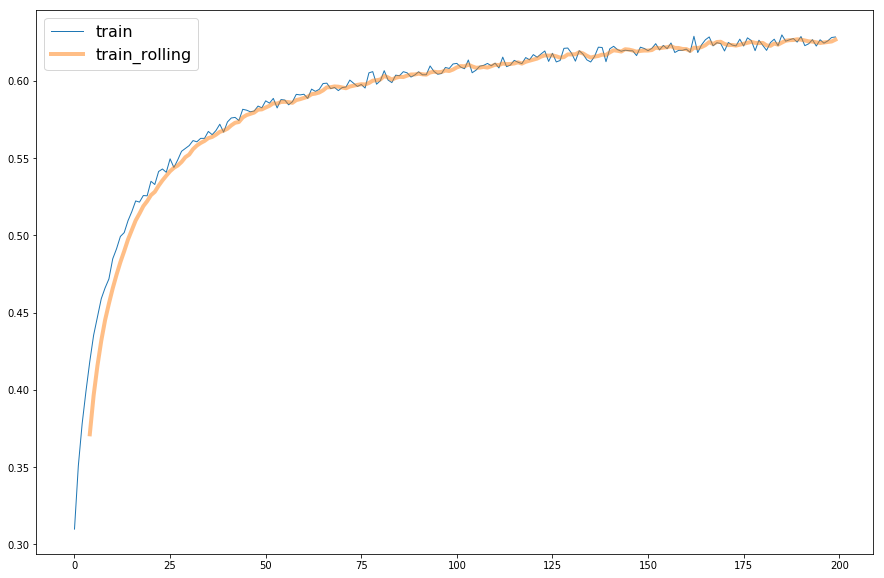

In [26]:
# append new values to a learning curve (extend epochs to see progress)
learn_curve_new = pd.DataFrame()
learn_curve_new['train'] = mod_history.history['acc']
learn_curve_new['train_rolling'] = pd.rolling_mean(learn_curve_new.train,window=5)
#append to previous df
learn_curve = learn_curve.append(learn_curve_new,ignore_index=True)
# Plot the learning curve
fig = plt.figure(figsize=(15, 10))
plt.plot(learn_curve['train'], lw=1, label='train')
plt.plot(learn_curve['train_rolling'], lw=4, label='train_rolling',alpha=.5)
plt.legend(loc='best', fontsize=16)

In [28]:
reduceLR = ReduceLROnPlateau(monitor='loss', factor=0.2, verbose=1, patience=10, min_lr=1e-7)

In [29]:
 # 6 Fit model on ALL (training) data

# steps_per_epoch should be (number of training images total / batch_size) 
# validation_steps should be (number of validation images total / batch_size)

print('Training')
mod_history = model.fit_generator(train_datagen.flow(traning_images_array, 
                                                    to_categorical(all_labels), 
                                                    batch_size=batch_size),
                                    steps_per_epoch=int(traning_images_array.shape[0]/batch_size),
                                    epochs=400, initial_epoch=200,
                                    verbose=1,
                                    class_weight=class_weights,
                                    callbacks = [reduceLR]
                                    #validation_data=val_generator,
                                    #validation_steps=int(validation_images_array.shape[0]/batch_size)+1
                                 )


Training
Epoch 201/400
378/378 [==============================] - 7s 19ms/step - loss: 1.3662 - acc: 0.6285
Epoch 202/400
378/378 [==============================] - 7s 19ms/step - loss: 1.3619 - acc: 0.6278
Epoch 203/400
378/378 [==============================] - 7s 19ms/step - loss: 1.3637 - acc: 0.6277
Epoch 204/400
378/378 [==============================] - 7s 19ms/step - loss: 1.3710 - acc: 0.6241
Epoch 205/400
378/378 [==============================] - 7s 19ms/step - loss: 1.3619 - acc: 0.6279
Epoch 206/400
378/378 [==============================] - 7s 19ms/step - loss: 1.3676 - acc: 0.6295
Epoch 207/400
378/378 [==============================] - 7s 19ms/step - loss: 1.3604 - acc: 0.6300
Epoch 208/400
378/378 [==============================] - 7s 19ms/step - loss: 1.3719 - acc: 0.6289
Epoch 209/400
378/378 [==============================] - 7s 20ms/step - loss: 1.3629 - acc: 0.6264
Epoch 210/400
378/378 [==============================] - 7s 19ms/step - loss: 1.3588 - acc: 0.6275
E

Epoch 282/400
378/378 [==============================] - 8s 21ms/step - loss: 1.1354 - acc: 0.6803
Epoch 283/400
378/378 [==============================] - 8s 20ms/step - loss: 1.1304 - acc: 0.6774
Epoch 284/400
378/378 [==============================] - 7s 20ms/step - loss: 1.1265 - acc: 0.6797
Epoch 285/400
378/378 [==============================] - 8s 20ms/step - loss: 1.1226 - acc: 0.6807
Epoch 286/400
378/378 [==============================] - 8s 20ms/step - loss: 1.1109 - acc: 0.6815
Epoch 287/400
378/378 [==============================] - 7s 19ms/step - loss: 1.1345 - acc: 0.6763
Epoch 288/400
378/378 [==============================] - 8s 21ms/step - loss: 1.1265 - acc: 0.6811
Epoch 289/400
378/378 [==============================] - 8s 21ms/step - loss: 1.1284 - acc: 0.6810
Epoch 290/400
378/378 [==============================] - 8s 20ms/step - loss: 1.1243 - acc: 0.6806
Epoch 291/400
378/378 [==============================] - 8s 20ms/step - loss: 1.1299 - acc: 0.6774
Epoch 292/

/home/antonis/anaconda2/envs/kaggle/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()


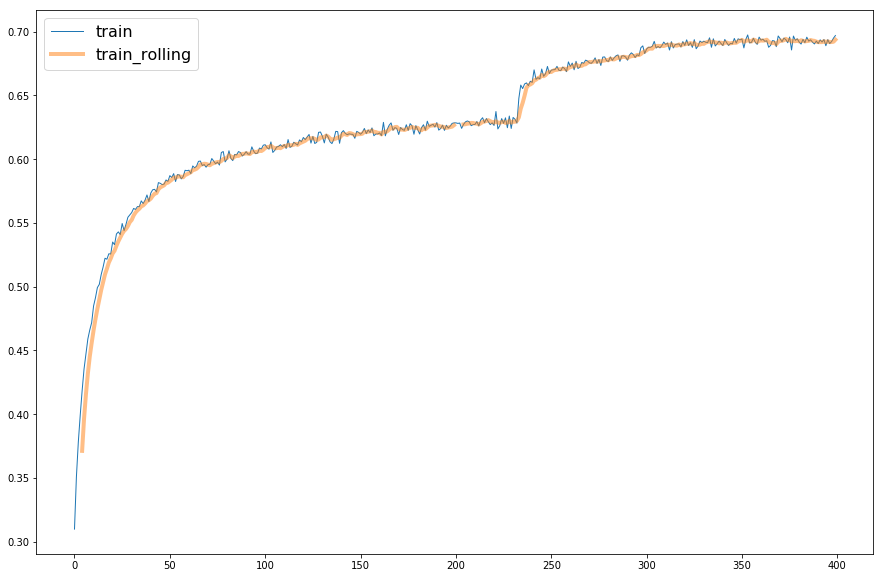

In [32]:
# append new values to a learning curve (extend epochs to see progress)
learn_curve_new = pd.DataFrame()
learn_curve_new['train'] = mod_history.history['acc']
learn_curve_new['train_rolling'] = pd.rolling_mean(learn_curve_new.train,window=5)
#append to previous df
learn_curve = learn_curve.append(learn_curve_new,ignore_index=True)
# Plot the learning curve
fig = plt.figure(figsize=(15, 10))
plt.plot(learn_curve['train'], lw=1, label='train')
plt.plot(learn_curve['train_rolling'], lw=4, label='train_rolling',alpha=.5)
plt.legend(loc='best', fontsize=16)

In [33]:
reduceLR = ReduceLROnPlateau(monitor='loss', factor=0.2, verbose=1, patience=5, min_lr=1e-14)

In [34]:
 # 6 Fit model on ALL (training) data

# steps_per_epoch should be (number of training images total / batch_size) 
# validation_steps should be (number of validation images total / batch_size)

print('Training')
mod_history = model.fit_generator(train_datagen.flow(traning_images_array, 
                                                    to_categorical(all_labels), 
                                                    batch_size=batch_size),
                                    steps_per_epoch=int(traning_images_array.shape[0]/batch_size),
                                    epochs=500, initial_epoch=400,
                                    verbose=1,
                                    class_weight=class_weights,
                                    callbacks = [reduceLR]
                                    #validation_data=val_generator,
                                    #validation_steps=int(validation_images_array.shape[0]/batch_size)+1
                                 )


Training
Epoch 401/500
378/378 [==============================] - 7s 19ms/step - loss: 1.0741 - acc: 0.6935
Epoch 402/500
378/378 [==============================] - 7s 19ms/step - loss: 1.0726 - acc: 0.6929
Epoch 403/500
378/378 [==============================] - 7s 19ms/step - loss: 1.0713 - acc: 0.6947
Epoch 404/500
378/378 [==============================] - 7s 19ms/step - loss: 1.0667 - acc: 0.6932
Epoch 405/500
378/378 [==============================] - 7s 19ms/step - loss: 1.0708 - acc: 0.6903
Epoch 406/500
378/378 [==============================] - 7s 19ms/step - loss: 1.0749 - acc: 0.6918
Epoch 407/500
378/378 [==============================] - 7s 19ms/step - loss: 1.0685 - acc: 0.6953
Epoch 408/500
378/378 [==============================] - 7s 20ms/step - loss: 1.0665 - acc: 0.6937
Epoch 409/500
378/378 [==============================] - 7s 20ms/step - loss: 1.0821 - acc: 0.6899
Epoch 410/500
378/378 [==============================] - 7s 19ms/step - loss: 1.0722 - acc: 0.6916
E

/home/antonis/anaconda2/envs/kaggle/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()


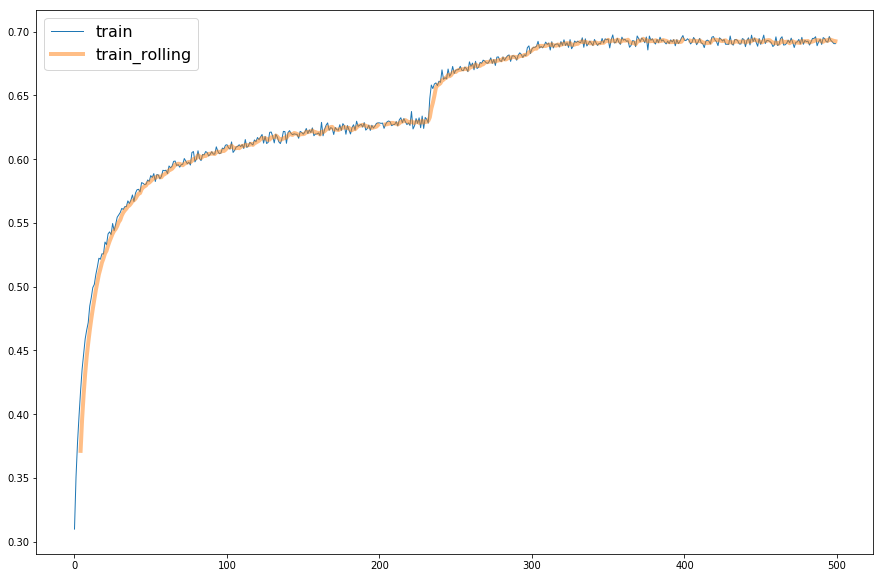

In [35]:
# append new values to a learning curve (extend epochs to see progress)
learn_curve_new = pd.DataFrame()
learn_curve_new['train'] = mod_history.history['acc']
learn_curve_new['train_rolling'] = pd.rolling_mean(learn_curve_new.train,window=5)
#append to previous df
learn_curve = learn_curve.append(learn_curve_new,ignore_index=True)
# Plot the learning curve
fig = plt.figure(figsize=(15, 10))
plt.plot(learn_curve['train'], lw=1, label='train')
plt.plot(learn_curve['train_rolling'], lw=4, label='train_rolling',alpha=.5)
plt.legend(loc='best', fontsize=16)

In [ ]:
##########

# Export model (history, summary and learning curves)


In [36]:

notes='finalCountD2, e**(1DIVx)'

In [37]:
from datetime import datetime
import pickle

In [38]:
#set filename
time= datetime.now().strftime('%m-%d %H.%M, ')
errors = 'train_err=%.2f'%(mod_history.history['acc'][-1])
ffilename = 'trainHistory/'+time+errors+notes

In [39]:
# Export model (history, summary and learning curves)

notes='log'                    # add any notes here
with open(ffilename + '.pickle', 'wb') as file_pi:         # export model history
    pickle.dump(mod_history.history, file_pi)
model.save(ffilename+'.h5')                                # export model


with open(ffilename + '_summary.txt','w') as fh:           # save model summary (layer architecture etc)
    model.summary(print_fn=lambda x: fh.write(x + '\n'))   # Pass the file handle in as a lambda function to make it callable

fig.savefig(ffilename+'_learning_curve.png')               # save learning curve image

In [40]:
# test_images_array_transf = test_datagen.standardize(test_images_array)
# # test_images_array_transf2 = test_datagen2.standardize(test_images_array)

In [41]:
test_images_array = test_datagen.standardize(test_images_array)

In [42]:
results = model.predict(test_images_array, batch_size=batch_size, verbose=1)

6132/6132 [==============================] - 1s 116us/step


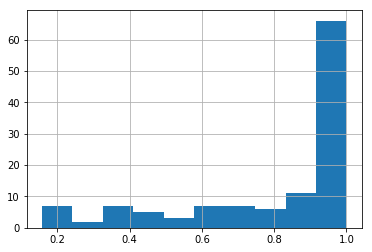

In [43]:
results_df = pd.DataFrame(results)
results_df.max(axis=0).hist()

In [44]:
from utils import filename_from_path
results_df.index = map(lambda p: filename_from_path(test_set_list[p]), results_df.index)
subm = results_df.idxmax(axis=1)
subm.head()

40283.jpg      28
10858.jpg       8
153813.jpg     84
14182.jpg      31
59486.jpg     113
dtype: int64

In [45]:
subm.to_csv(notes+'.csv',header=['class'],index_label='image')